# Libraries

In [1827]:
import os
import random
import warnings 
import holidays
import numpy as np
import pandas as pd
import optuna
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

plt.style.use('ggplot')

from IPython.display import display
from matplotlib.pyplot import figure
from optuna.pruners import MedianPruner
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

warnings.filterwarnings('ignore')

In [1828]:
# Fix seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Force reproducibility (may slow down training)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

# Data Loading

In [1829]:
# Load the first dataset
df_forecast = pd.read_csv(
    r"E:\UNSW\Courses\2025 Hexamester 2 ZZSC9020-Data Science Project (H225 Online)\Project\Data\forecastdemand_nsw.csv",
    usecols=["FORECASTDEMAND", "DATETIME"]
)

# Load the second dataset
df_temp = pd.read_csv(
    r"E:\UNSW\Courses\2025 Hexamester 2 ZZSC9020-Data Science Project (H225 Online)\Project\Data\temperature_nsw.csv", 
    usecols=["TEMPERATURE", "DATETIME"]
)


# Load the third dataset
df_demand = pd.read_csv(
    r"E:\UNSW\Courses\2025 Hexamester 2 ZZSC9020-Data Science Project (H225 Online)\Project\Data\totaldemand_nsw.csv", 
    usecols=["TOTALDEMAND", "DATETIME"]                      
)


# Data Cleaning, Exploring and Processing

In [1830]:
# Remove spaces from DATETIME columns
df_forecast["DATETIME"] = df_forecast["DATETIME"].astype(str).str.strip()
df_temp["DATETIME"] = df_temp["DATETIME"].astype(str).str.strip()
df_demand["DATETIME"] = df_demand["DATETIME"].astype(str).str.strip()

# Aggregate FORECASTDEMAND by DATETIME using the MEAN
df_forecast = df_forecast.groupby("DATETIME")["FORECASTDEMAND"].agg(
    FORECASTING="mean"
).reset_index()

# Define the correct DATETIME format
datetime_format = "%d/%m/%Y %H:%M"
# Convert 'DATETIME' column with explicit format
df_forecast["DATETIME"] = pd.to_datetime(df_forecast["DATETIME"], errors="coerce", infer_datetime_format=True)
df_temp["DATETIME"] = pd.to_datetime(df_temp["DATETIME"], format=datetime_format, errors="coerce")
df_demand["DATETIME"] = pd.to_datetime(df_demand["DATETIME"], format=datetime_format, errors="coerce")

df_forecast.set_index('DATETIME', inplace=True)
df_temp.set_index('DATETIME', inplace=True)
df_demand.set_index('DATETIME', inplace=True)

In [1831]:
# Keep the first and drop the rest
df_forecast = df_forecast[~df_forecast.index.duplicated(keep='first')]
df_temp = df_temp[~df_temp.index.duplicated(keep='first')]
df_demand = df_demand[~df_demand.index.duplicated(keep='first')]

# Check duplicates again
print("Duplicate timestamps in df_forecast:", df_forecast.index.duplicated().sum())
print("Duplicate timestamps in df_temp:", df_temp.index.duplicated().sum())
print("Duplicate timestamps in df_demand:", df_demand.index.duplicated().sum())


Duplicate timestamps in df_forecast: 0
Duplicate timestamps in df_temp: 0
Duplicate timestamps in df_demand: 0


In [1832]:
# Generate complete 30-minute range from min to max time
expected_index = pd.date_range(
    start=df_temp.index.min(),
    end=df_temp.index.max(),
    freq='30T'
)

# Reindex to find missing rows
df_temp_reindexed = df_temp.reindex(expected_index)

# Find missing timestamps
missing_timestamps = df_temp_reindexed[df_temp_reindexed.isnull().any(axis=1)].index

# Show how many and preview them
print(f"Missing 30-min intervals Temp Table: {len(missing_timestamps)}")
print(missing_timestamps[:10])  # Show first 10 missing rows

# Generate complete 30-minute range from min to max time
expected_index = pd.date_range(
    start=df_demand.index.min(),
    end=df_demand.index.max(),
    freq='30T'
)

# Reindex to find missing rows
df_demand_reindexed = df_demand.reindex(expected_index)

# Find missing timestamps
missing_timestamps = df_demand_reindexed[df_demand_reindexed.isnull().any(axis=1)].index

# Show how many and preview them
print(f"Missing 30-min intervals Demand Table: {len(missing_timestamps)}")
# Show first 10 missing rows
print(missing_timestamps[:10])  


Missing 30-min intervals Temp Table: 579
DatetimeIndex(['2010-01-10 04:00:00', '2010-01-11 17:00:00',
               '2010-01-14 13:30:00', '2010-01-15 10:30:00',
               '2010-01-16 10:30:00', '2010-01-19 00:30:00',
               '2010-01-19 10:30:00', '2010-01-20 15:30:00',
               '2010-01-21 18:00:00', '2010-01-23 08:30:00'],
              dtype='datetime64[ns]', freq=None)
Missing 30-min intervals Demand Table: 0
DatetimeIndex([], dtype='datetime64[ns]', freq='30min')


In [1833]:
df_temp_reindexed['TEMPERATURE'] = df_temp_reindexed['TEMPERATURE'].fillna(method='ffill')

# Rename index back to 'DATETIME'
df_temp_reindexed.index.name = 'DATETIME'

# Final updated temperature dataset
df_temp = df_temp_reindexed

print(f"\nFinal shape: {df_temp.shape}")
print(f"Remaining missing values:\n{df_temp.isna().sum()}")


Final shape: (196513, 1)
Remaining missing values:
TEMPERATURE    0
dtype: int64


In [1834]:
# Merge all datasets into a single DataFrame based on DATETIME
df = pd.merge(pd.merge(df_demand, df_forecast, on='DATETIME', how='inner'), df_temp, on='DATETIME', how='inner')

In [1835]:
df_filtered = df[(df.index.minute == 0) & (~df.index.year.isin([2021]))]
df_filtered = df_filtered.sort_index()
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96432 entries, 2010-01-01 00:00:00 to 2020-12-31 23:00:00
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TOTALDEMAND  96432 non-null  float64
 1   FORECASTING  96432 non-null  float64
 2   TEMPERATURE  96432 non-null  float64
dtypes: float64(3)
memory usage: 2.9 MB


# Feature Engineering

In [1836]:
# Ensure datetime index exists

df_filtered["DATE"] = df_filtered.index.date
df_filtered["MONTH"] = df_filtered.index.month
df_filtered["DAYOFWEEK"] = df_filtered.index.dayofweek
df_filtered["HOUR"] = df_filtered.index.hour

# Create lag features
df_filtered["LAG_24H"] = df["TOTALDEMAND"].shift(24)
df_filtered["LAG_48H"] = df["TOTALDEMAND"].shift(48)

df_filtered = df_filtered.dropna(subset=["LAG_24H", "LAG_48H"])


# Weekend flag
df_filtered["IS_WEEKEND"] = df_filtered["DAYOFWEEK"].isin([5, 6]).astype(bool)

# Season column
df_filtered["SEASON"] = df_filtered.apply(
    lambda row: (
        "Summer" if row["MONTH"] in [11, 12, 1, 2, 3] else (
            "Winter" if row["MONTH"] in [6, 7, 8] else (
                "Spring" if row["MONTH"] in [9, 10] else "Autumn"
            )
        )
    ),
    axis=1
)

# Public Holidays using `holidays` package
nsw_holidays = holidays.Australia(prov="NSW", years=range(2010, 2021))
holiday_dates = [date for date in nsw_holidays.keys()]

# New Year extension (Dec 31 – Jan 2 each year)
new_year_ranges = [(f"{year-1}-12-31", f"{year}-01-02") for year in range(2010, 2021)]
new_year_dates = []
for start, end in new_year_ranges:
    new_year_dates.extend(pd.date_range(start=start, end=end))

# Public holiday flag
df_filtered["IS_PUBLIC_HOLIDAY"] = (
    df_filtered["DATE"].isin(holiday_dates) | df_filtered["DATE"].isin(new_year_dates)
).astype(bool)

# Temperature-based features
df_filtered["TEMP_SQUARED"] = df_filtered["TEMPERATURE"] ** 2

# Convert datetime index to timestamp in seconds
timestamp_s = df_filtered.index.map(pd.Timestamp.timestamp)

# Define constants
day = 24 * 60 * 60
year = 365.2425 * day  # Account for leap years

# Create cyclical time features
df_filtered["DAY_SIN"] = np.sin(2 * np.pi * timestamp_s / day)
df_filtered["DAY_COS"] = np.cos(2 * np.pi * timestamp_s / day)
df_filtered["YEAR_SIN"] = np.sin(2 * np.pi * timestamp_s / year)
df_filtered["YEAR_COS"] = np.cos(2 * np.pi * timestamp_s / year)

In [1837]:
# Drop unused columns
df_filtered.drop(columns=["DATE", "FORECASTING"], inplace=True, errors='ignore')

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96408 entries, 2010-01-02 00:00:00 to 2020-12-31 23:00:00
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TOTALDEMAND        96408 non-null  float64
 1   TEMPERATURE        96408 non-null  float64
 2   MONTH              96408 non-null  int32  
 3   DAYOFWEEK          96408 non-null  int32  
 4   HOUR               96408 non-null  int32  
 5   LAG_24H            96408 non-null  float64
 6   LAG_48H            96408 non-null  float64
 7   IS_WEEKEND         96408 non-null  bool   
 8   SEASON             96408 non-null  object 
 9   IS_PUBLIC_HOLIDAY  96408 non-null  bool   
 10  TEMP_SQUARED       96408 non-null  float64
 11  DAY_SIN            96408 non-null  float64
 12  DAY_COS            96408 non-null  float64
 13  YEAR_SIN           96408 non-null  float64
 14  YEAR_COS           96408 non-null  float64
dtypes: bool(2), float64(9), int32(3), o

In [1838]:
# copy for modeling
df_model = df_filtered.copy()

# One-hot encode for SEASON 
df_model = pd.get_dummies(df_model, columns=["SEASON"], drop_first=True)

df_model = df_model.sort_index()


In [1839]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96408 entries, 2010-01-02 00:00:00 to 2020-12-31 23:00:00
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TOTALDEMAND        96408 non-null  float64
 1   TEMPERATURE        96408 non-null  float64
 2   MONTH              96408 non-null  int32  
 3   DAYOFWEEK          96408 non-null  int32  
 4   HOUR               96408 non-null  int32  
 5   LAG_24H            96408 non-null  float64
 6   LAG_48H            96408 non-null  float64
 7   IS_WEEKEND         96408 non-null  bool   
 8   IS_PUBLIC_HOLIDAY  96408 non-null  bool   
 9   TEMP_SQUARED       96408 non-null  float64
 10  DAY_SIN            96408 non-null  float64
 11  DAY_COS            96408 non-null  float64
 12  YEAR_SIN           96408 non-null  float64
 13  YEAR_COS           96408 non-null  float64
 14  SEASON_Spring      96408 non-null  bool   
 15  SEASON_Summer      96408 non-null  

# Prepare Data Before Modeling

**Forecast Horizons (forecast_horizon) : 1, 6, 12 and 24 hours.
Each model was trained separately for one horizon at a time, 
and you need to manually switch the horizon before training each run.** 

In [1840]:
forecast_horizon = 1
# 24, 48 and 72 window size
window_size = 24         

# Prepare Features
X = df_model.drop(columns=["TOTALDEMAND"])
y = df_model["TOTALDEMAND"]

# Fit scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Combine for sequence creation
data_scaled = np.hstack((X_scaled, y_scaled))

# Create Sequences
def create_sequences(data, window_size, horizon=1):
    X_seq, y_seq = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X_seq.append(data[i:i+window_size, :-1])              # input features
        y_seq.append(data[i+window_size + horizon - 1, -1])   # target value at t+h
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(data_scaled, window_size, forecast_horizon)

# Time-Based Split
total_size = len(X_seq)
train_size = int(total_size * 0.7)
val_size = int(total_size * 0.15)

# Chronological slicing
X_train = X_seq[:train_size]
y_train = y_seq[:train_size]

X_valid = X_seq[train_size:train_size + val_size]
y_valid = y_seq[train_size:train_size + val_size]

X_test = X_seq[train_size + val_size:]
y_test = y_seq[train_size + val_size:]

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


**This function below is used for hyperparameter tuning.
Since it takes several hours to run, the best parameter set has already been determined, so you don’t need to run it again.** 

In [1841]:
def objective(trial, ml="lstm"):
    # Suggest hyperparameters
    
    n_units = trial.suggest_categorical("n_units", [32, 64, 128])  
    dropout_rate = trial.suggest_float("dropout", 0.001, 0.02, log=True)  
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    # Build model
    model = Sequential()

    if ml == "lstm":
        model.add(LSTM(n_units, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=dropout_rate))
    elif ml == "gru":
        model.add(GRU(n_units, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=dropout_rate))
    else:
        raise ValueError("Model type must be 'lstm'")

    # Additional Dense layer + Dropout to reduce overfitting
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(1))

    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mae", metrics=["mae"])

    # Callbacks
    early_stop = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=1, factor=0.5, min_lr=1e-5)
    
    pruning_callback = TFKerasPruningCallback(trial, "val_loss")

    # Use fewer epochs for tuning (to speed it up)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=50,  # Reduce from 50 to 20 for faster search
        batch_size=batch_size,
        callbacks=[early_stop, reduce_lr, pruning_callback],
        verbose=0
    )

    return min(history.history["val_loss"])


**The optimizer call is not required, as the best parameters are already provided in the next block.**

In [1842]:
'''
study = optuna.create_study(direction='minimize', pruner=MedianPruner(), sampler=optuna.samplers.TPESampler(n_startup_trials=5))
study.optimize(lambda trial: objective(trial, ml="lstm"), n_trials=50, show_progress_bar=True)

# Print results
best_params_lstm = study.best_params
print("Best LSTM hyperparameters:", best_params_lstm)
'''

'\nstudy = optuna.create_study(direction=\'minimize\', pruner=MedianPruner(), sampler=optuna.samplers.TPESampler(n_startup_trials=5))\nstudy.optimize(lambda trial: objective(trial, ml="lstm"), n_trials=50, show_progress_bar=True)\n\n# Print results\nbest_params_lstm = study.best_params\nprint("Best LSTM hyperparameters:", best_params_lstm)\n'

In [1843]:

#Forecast Hirizone Best Hyperparameters: 
# 1-Hour : 'n_units': 128, 'dropout': 0,  'lr': 0.001, 'batch_size': 64
# 6-Hour : 'n_units': 128, 'dropout': 0,  'lr': 0.001, 'batch_size': 32
# 12-Hour : 'n_units': 128, 'dropout': 0,  'lr': 0.001, 'batch_size': 64
# 24-Hour : 'n_units': 128, 'dropout': 0,  'lr': 0.001, 'batch_size': 32

best_params_lstm = {
    'n_units': 128,           
    'dropout': 0,        
    'lr': 0.001,  
    'batch_size': 64
}


In [1844]:
# EarlyStopping is used to prevent overfitting by stopping training 
# when the model's performance on the validation set stops improving.
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5, min_lr=1e-5)

# Build & Train LSTM Model

In [1845]:
model_lstm = Sequential()
model_lstm.add(LSTM(best_params_lstm["n_units"], dropout=best_params_lstm["dropout"],
                     return_sequences=True,
                   input_shape=(X_train.shape[1], X_train.shape[2])))

model_lstm.add(LSTM(64))
# Fully connected layers
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1))  # Output

model_lstm.summary()

model_lstm.compile(optimizer=Adam(learning_rate=best_params_lstm["lr"]), loss="mae", metrics=["mae"])

history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=50,
    batch_size=best_params_lstm["batch_size"],
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# === Predict using LSTM and GRU models ===
y_pred_lstm = model_lstm.predict(X_test)


Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_80 (LSTM)                  │ (None, 64)             │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,961 (97.50 KB)

 Trainable params: 24,961 (97.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 62s 53ms/step - loss: 0.0822 - mae: 0.0822 - val_loss: 0.0449 - val_mae: 0.0449 - learning_rate: 0.0010
Epoch 2/50
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 50s 47ms/step - loss: 0.0467 - mae: 0.0467 - val_loss: 0.0384 - val_mae: 0.0384 - learning_rate: 0.0010
Epoch 3/50
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - loss: 0.0413 - mae: 0.0413 - val_loss: 0.0346 - val_mae: 0.0346 - learning_rate: 0.0010
Epoch 4/50
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 45s 43ms/step - loss: 0.0387 - mae: 0.0387 - val_loss: 0.0353 - val_mae: 0.0353 - learning_rate: 0.0010
Epoch 5/50
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 50s 48ms/step - loss: 0.0369 - mae: 0.0369 - val_loss: 0.0331 - val_mae: 0.0331 - learning_rate: 0.0010
Epoch 6/50
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - loss: 0.0357 - mae: 0.0357 - val_loss: 0.0322 - val_mae: 0.0322 - learning_rate: 0.0010
Epoch 7/50
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 50s 47ms/step - loss: 0.0350 - mae: 0.0350 - val_loss: 0.0319 - val_mae: 0.0319 - 

In [1846]:
# Reshape y_test 
if y_test.ndim == 1:
    y_test = y_test.reshape(-1, 1)

# Inverse transform
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_lstm_inv = scaler_y.inverse_transform(y_pred_lstm)
#y_pred_gru_inv = scaler_y.inverse_transform(y_pred_gru)

In [1847]:
# Function to evaluate metrics
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-10, None))) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "MAPE (%)": mape, "RMSE": rmse, "R² Score": r2}

# Calculate metrics
metrics_lstm = evaluate_model(y_test_inv, y_pred_lstm_inv)
#metrics_gru = evaluate_model(y_test_inv, y_pred_gru_inv)

# Display in a table
results_df = pd.DataFrame([metrics_lstm], index=["LSTM"])
results_df = results_df.round(5)

display(results_df)

,MAE,MAPE (%),RMSE,R² Score
LSTM,290.55996,3.65736,452.91108,0.86525


# Visualisation

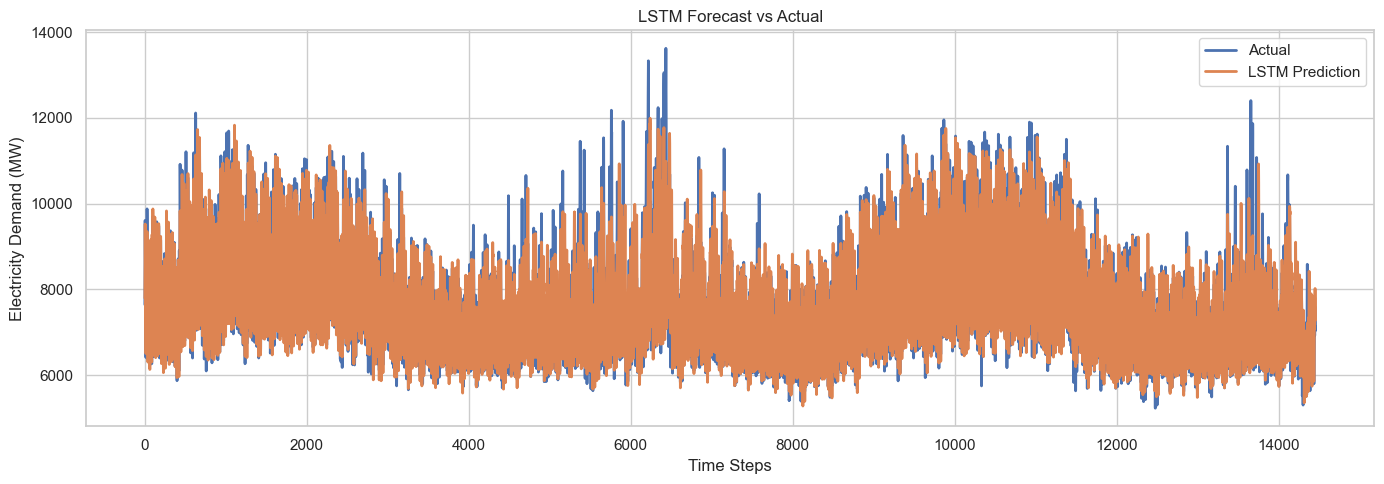

In [1855]:
plt.figure(figsize=(14, 5))

# LSTM vs Actual
plt.plot(y_test_inv, label="Actual", linewidth=2)
plt.plot(y_pred_lstm_inv, label="LSTM Prediction", linewidth=2)
plt.title("LSTM Forecast vs Actual")
plt.xlabel("Time Steps")
plt.ylabel("Electricity Demand (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


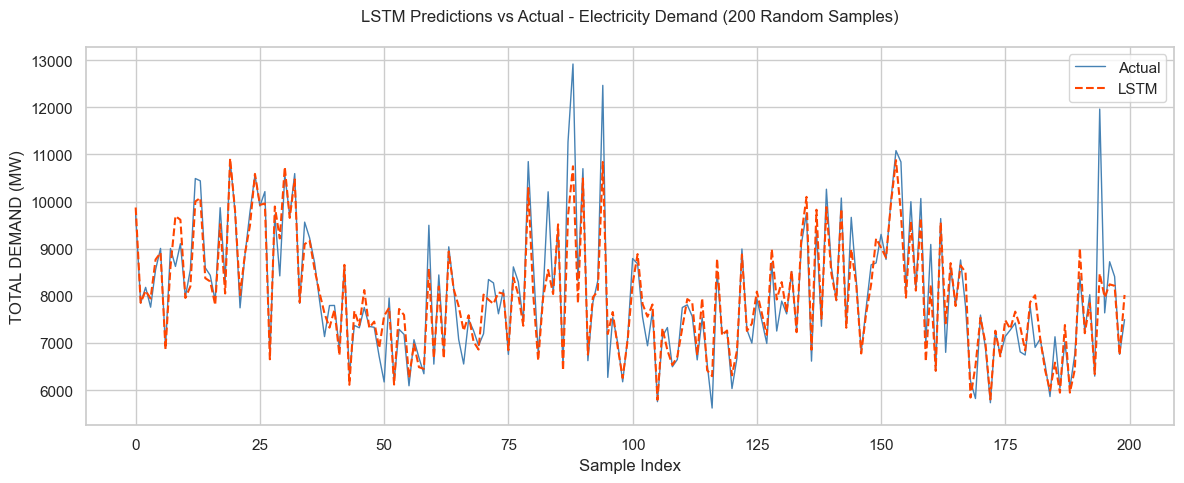

In [1856]:
sns.set(style='whitegrid')
np.random.seed(42)  # For reproducibility
random_indices = np.random.choice(len(y_test_inv), 200, replace=False)
random_indices.sort()  # Keep temporal order

plt.figure(figsize=(12, 5))

# LSTM Predictions vs Actual
plt.plot(y_test_inv[random_indices], label='Actual', color='steelblue', linewidth=1)
plt.plot(y_pred_lstm_inv[random_indices], label='LSTM', color='orangered', linestyle='--')
plt.title('LSTM Predictions vs Actual - Electricity Demand (200 Random Samples)\n', fontsize=12)
plt.xlabel('Sample Index')
plt.ylabel('TOTAL DEMAND (MW)')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


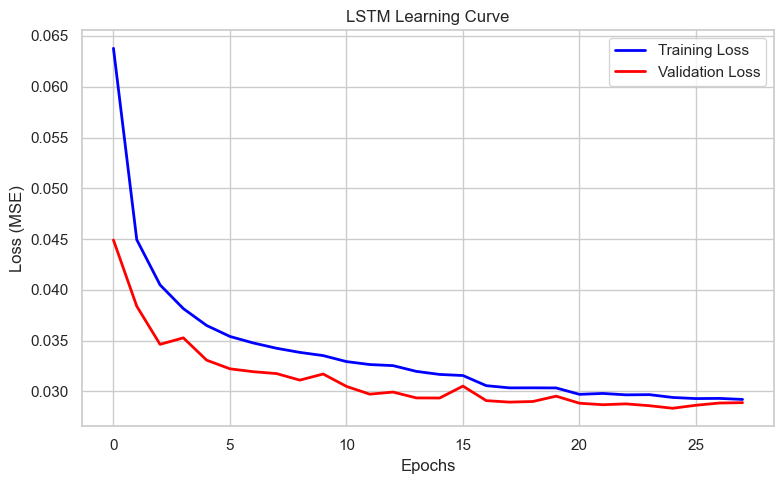

In [1857]:
sns.set(style='whitegrid')

# Training and validation losses
train_loss_lstm = history_lstm.history["loss"]
val_loss_lstm = history_lstm.history["val_loss"]

plt.figure(figsize=(8, 5))

# LSTM Learning Curve
plt.plot(train_loss_lstm, label='Training Loss', color='blue', linewidth=2)
plt.plot(val_loss_lstm, label='Validation Loss', color='red', linewidth=2)
plt.title("LSTM Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


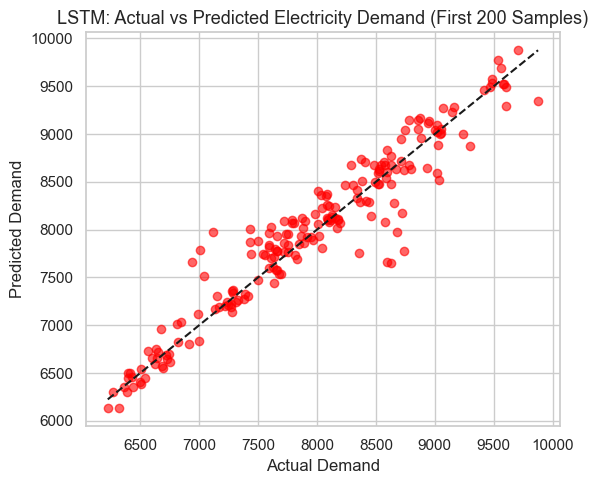

In [1858]:
sns.set(style='whitegrid')

# Actual and LSTM-predicted values (first 200)
y_actual = y_test_inv[:200].flatten()
y_pred_lstm = y_pred_lstm_inv[:200].flatten()

plt.figure(figsize=(6, 5))

# Scatter plot: Actual vs Predicted
plt.scatter(y_actual, y_pred_lstm, c='red', alpha=0.6)
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'k--')
plt.xlabel("Actual Demand", fontsize=12)
plt.ylabel("Predicted Demand", fontsize=12)
plt.title("LSTM: Actual vs Predicted Electricity Demand (First 200 Samples)", fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.show()


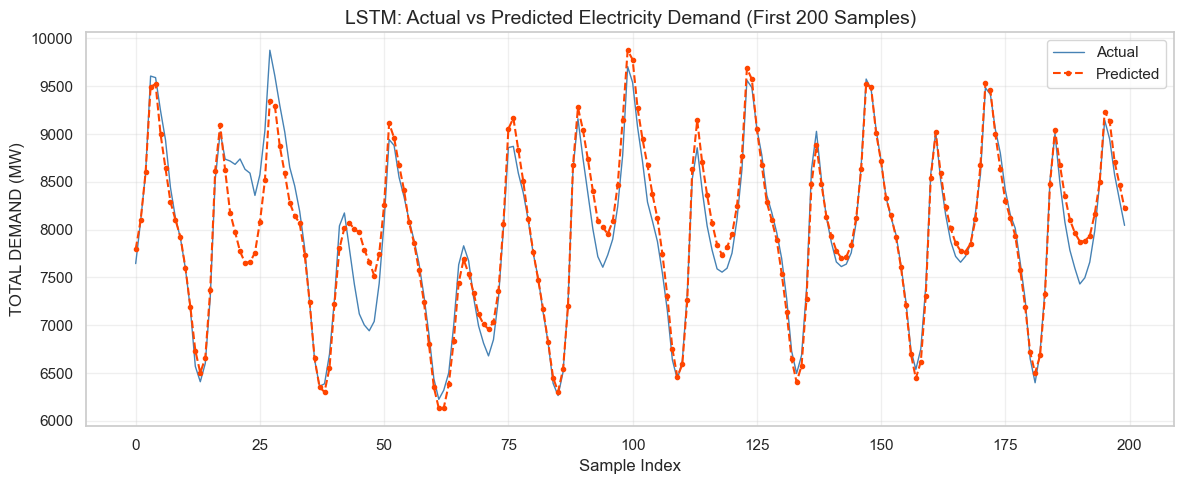

In [1859]:
df_plot = pd.DataFrame({
    'ACTUAL': y_test_inv.flatten(),
    'PRED_LSTM': y_pred_lstm_inv.flatten()
})

plt.figure(figsize=(12, 5))

plt.plot(df_plot['ACTUAL'].iloc[:200], label='Actual', color='steelblue', linewidth=1)
plt.plot(df_plot['PRED_LSTM'].iloc[:200], label='Predicted', color='orangered', linestyle='--', marker='.')
plt.title("LSTM: Actual vs Predicted Electricity Demand (First 200 Samples)", fontsize=14)
plt.xlabel("Sample Index")
plt.ylabel("TOTAL DEMAND (MW)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


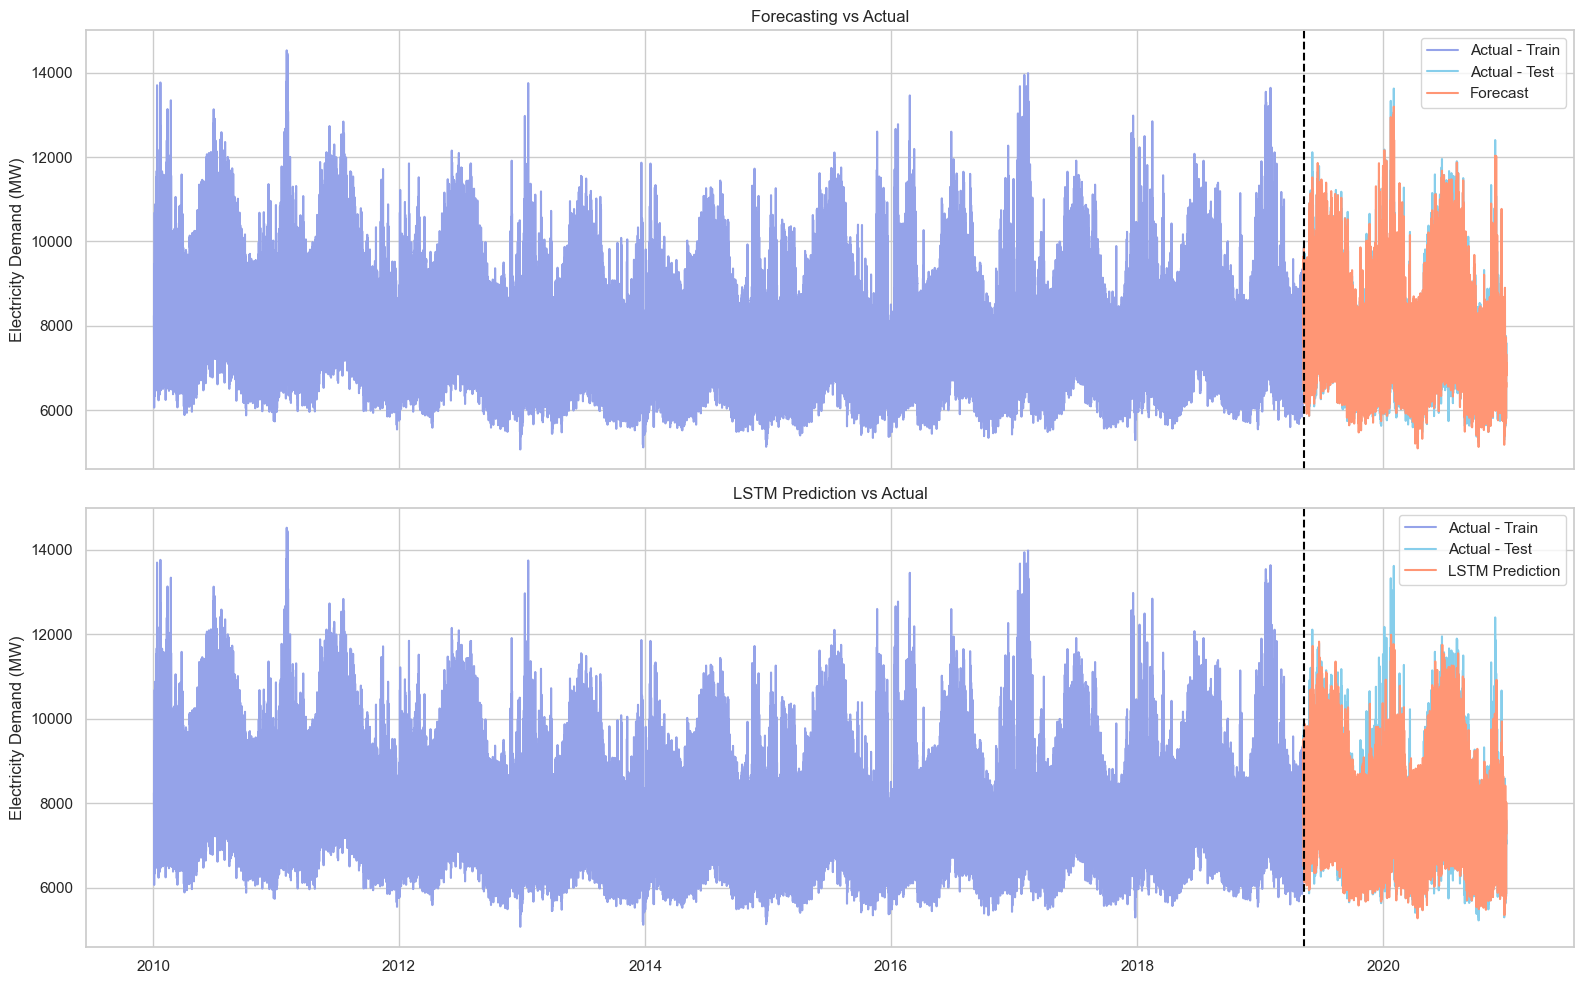

In [1863]:
# Calculate the starting index for predictions
y_index_start = window_size + forecast_horizon - 1
y_full_index = df_model.index[y_index_start:]

# Create correct time indices
y_train_index = y_full_index[:len(y_train)]
y_valid_index = y_full_index[len(y_train):len(y_train) + len(y_valid)]
y_test_index = y_full_index[len(y_train) + len(y_valid):]

# Prepare df_preds with only new models
df_preds = pd.DataFrame({
    "Actual": scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten(),
    "Forecasting": df.loc[y_test_index, "FORECASTING"].values,
    "LSTM": y_pred_lstm_inv.flatten()
}, index=y_test_index)

actual_train = pd.Series(
    scaler_y.inverse_transform(np.concatenate([y_train, y_valid]).reshape(-1, 1)).flatten(),
    index=y_train_index.append(y_valid_index)
)

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 10), sharex=True)

# Forecasting vs Actual
axes[0].plot(actual_train.index, actual_train, label="Actual - Train", color="#95A3E9")
axes[0].plot(df_preds.index, df_preds["Actual"], label="Actual - Test", color="skyblue")
axes[0].plot(df_preds.index, df_preds["Forecasting"], label="Forecast", color="#FF9675")
axes[0].axvline(x=df_preds.index[0], color='black', linestyle='--')
axes[0].set_title("Forecasting vs Actual")
axes[0].set_ylabel("Electricity Demand (MW)")
axes[0].legend()

# LSTM vs Actual
axes[1].plot(actual_train.index, actual_train, label="Actual - Train", color="#95A3E9")
axes[1].plot(df_preds.index, df_preds["Actual"], label="Actual - Test", color="skyblue")
axes[1].plot(df_preds.index, df_preds["LSTM"], label="LSTM Prediction", color="#FF9675")
axes[1].axvline(x=df_preds.index[0], color='black', linestyle='--')
axes[1].set_title("LSTM Prediction vs Actual")
axes[1].set_ylabel("Electricity Demand (MW)")
axes[1].legend()

plt.tight_layout()
plt.show()
